In [1]:
# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os

## DATA PREPROCESSING

In [37]:
DIRECTORY = r"C:\Users\crazy\Desktop\mask detection\dataset"
CATEGORIES = ["with_mask", "without_mask"]

# grab the list of images in our dataset directory, then initialize
# the list of data (i.e., images) and class images


In [5]:
data = []
labels = []
for category in CATEGORIES:
    path = os.path.join(DIRECTORY, category)
    for img in os.listdir(path):
        img_path = os.path.join(path, img)
        image = load_img(img_path, target_size=(224, 224))
        image = img_to_array(image)
        image = preprocess_input(image)

        data.append(image)
        labels.append(category)

C:\ProgramData\Anaconda3\lib\site-packages\PIL\Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [25]:
lb = LabelBinarizer() 
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

In [30]:
data = np.array(data, dtype="float32")
labels = np.array(labels)

In [35]:
(trainX, testX, trainY, testY) = train_test_split(data, labels,test_size=0.20, stratify=labels, random_state=42)

## TRAINING

In [38]:
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

In [39]:
#generates more images with changing original proprities
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

In [46]:
#imagnet: standard initialisation for image's weights better than RANDOM
#incluse_top: include fully connected layer

# load the MobileNetV2 network, ensuring the head FC layer sets are
# left off
baseModel = MobileNetV2(weights="imagenet", include_top=False,
                         input_shape=(224, 224,3))

# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output 
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)


[INFO] compiling model...
[INFO] training head...
Epoch 1/20
95/95 [==============================] - 179s 2s/step - loss: 0.5541 - accuracy: 0.7471 - val_loss: 0.1336 - val_accuracy: 0.9857
Epoch 2/20
95/95 [==============================] - 165s 2s/step - loss: 0.1669 - accuracy: 0.9642 - val_loss: 0.0706 - val_accuracy: 0.9935
Epoch 3/20
95/95 [==============================] - 176s 2s/step - loss: 0.0980 - accuracy: 0.9779 - val_loss: 0.0501 - val_accuracy: 0.9935
Epoch 4/20
95/95 [==============================] - 176s 2s/step - loss: 0.0860 - accuracy: 0.9762 - val_loss: 0.0435 - val_accuracy: 0.9922
Epoch 5/20
95/95 [==============================] - 174s 2s/step - loss: 0.0740 - accuracy: 0.9790 - val_loss: 0.0366 - val_accuracy: 0.9935
Epoch 6/20
95/95 [==============================] - 183s 2s/step - loss: 0.0658 - accuracy: 0.9808 - val_loss: 0.0331 - val_accuracy: 0.9935
Epoch 7/20
95/95 [==============================] - 177s 2s/step - loss: 0.0624 - accuracy: 0.9784 - val

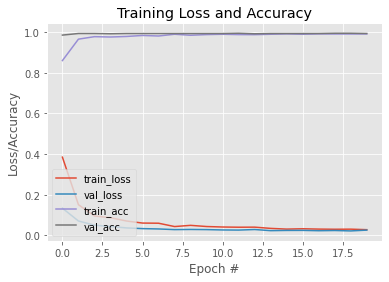

In [47]:
# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = False

# compile our model
print("[INFO] compiling model...")
#Adam optimizer
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
#accuracy metrics
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])

# train the head of the network
print("[INFO] training head...")
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)

# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))

# serialize the model to disk
print("[INFO] saving mask detector model...")
model.save("mask_detector.model", save_format="h5")

# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")


In [3]:
from tensorflow.keras.models import load_model
maskNet = load_model("mask_detector.model")

In [33]:
import cv2
img_path= r"C:\Users\crazy\Desktop\mask detection\Face-Mask-Detection\dataset\with_mask\1.jpg"


In [34]:
faces=[]
face= cv2.imread(img_path)
face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
face = cv2.resize(face, (224, 224))
face = img_to_array(face)
face = preprocess_input(face)
faces.append(face)
faces = np.array(faces, dtype="float32")
preds = maskNet.predict(faces, batch_size=32)

In [35]:
face.shape

(224, 224, 3)

In [40]:
preds

array([[9.9974495e-01, 2.5507036e-04]], dtype=float32)